# Introduction to   
# `SEML`: Slurm Experiment Management Library

## Why `SEML`?

In a nutshell, **`SEML`** enables you to leverage the massive parallelization of a compute cluster without boilerplate code or having to worry about keeping track of experiments.
That is, it enables you to:
* very easily define hyperparameter search spaces using YAML files,
* run these hyperparameter configurations on a compute cluster using `Slurm`,
* and to track the experimental results using `sacred` and `MongoDB`.


In addition, **`SEML`** offers many more features to make your life easier, such as
* automatically saving and loading your source code for reproducibility,
* collecting experiment results into a `Pandas` dataframe,
* easy debugging on Slurm or locally,
* automatically checking your experiment configurations,
* extending Slurm with local workers,
* and keeping track of resource usage (experiment runtime, RAM, etc.).

You can even get notified on Mattermost whenever an experiment starts, completes, or fails!

## How does it work?
<center><img src="./seml.pdf"/></center>

## How does it work?
* **`SEML`** takes a `YAML` file containing hyperparameters and metadata about a set of experiments.
* **`SEML`** stores each individual experiment's data as an entry in a `MongoDB` database collection.
* In general, each type of experiments gets their own database collection.
* Each individual experiment is an entry in the respective collection.
* A database entry is essentially a `JSON` dictionary containing (among others):
  * the state of the experiment
  * the experiment configuration (i.e., hyperparameters),
  * the generated results, and
  * the cached source code (by default).

## Demo workflow
* Show example experiment (return e.g. `log(learning rate)`)
* Show `yaml` file, play around with parameters, explain `sbatch_options`
* add, status, start, etc, add again (adds no duplicates)
* show `squeue`, database entries
* Add exception to experiment
* run again, show status, reload sources, reset, start
* load results and plot
* show jupyter job starting

In [1]:
from IPython.display import display, Markdown
with open('example_experiment.py', 'r') as f:
    code = f.read()
display(Markdown(f'''```python
{code}
```
'''
                ))

```python
import logging
from sacred import Experiment
import numpy as np
import seml
import time

ex = Experiment()
seml.setup_logger(ex)


@ex.config
def config():
    overwrite = None
    db_collection = None
    if db_collection is not None:
        ex.observers.append(seml.create_mongodb_observer(db_collection, overwrite=overwrite))


@ex.automain
def run(hidden_sizes: list, learning_rate: float, max_epochs: int):
    # Note that regularization_params contains the corresponding sub-dictionary from the configuration.
    logging.info('Received the following configuration:')
    logging.info(f'Hidden sizes: {hidden_sizes}, learning_rate: {learning_rate}, '
                 f'max_epochs: {max_epochs}')
    # res = hidden_sizes / 2
    #  do your processing here
    time.sleep(60)
    results = {
        'test_acc': learning_rate * np.sqrt(np.arange(1, 1001, 1)) + np.random.uniform(0, 5),
        # ...
    }
    # the returned result will be written into the database
    return results

```


In [2]:
with open('example_config.yaml', 'r') as f:
    config = f.read()
display(Markdown(f'''```yaml
{config}
```
'''))

```yaml
seml:
  executable: examples/tutorial/example_experiment.py
  name: example_experiment
  output_dir: examples/logs
  project_root_dir: ../..

slurm:
  experiments_per_job: 1
  sbatch_options:
    gres: gpu:1       # num GPUs
    mem: 16G          # memory
    cpus-per-task: 2  # num cores
    time: 0-08:00     # max time, D-HH:MM

fixed:
  max_epochs: 500

grid:
  learning_rate:
    type: choice
    options:
      - 1
      - 2
      - 3

small_datasets:
  fixed:
    hidden_sizes: [32, 16] # this will be parsed into a Python list.

large_datasets:

  fixed:
    hidden_sizes: [128, 64, 32]

```


In [3]:
! seml seml_tutorial add example_config.yaml

Adding 6 configs to the database (batch-ID 1).


In [4]:
! seml seml_tutorial status

********** Report for database collection 'seml_tutorial' **********
*     -   6 staged experiments
*     -   0 pending experiments
*     -   0 running experiments
*     -   0 completed experiments
*     -   0 interrupted experiments
*     -   0 failed experiments
*     -   0 killed experiments
********************************************************************


In [5]:
! seml seml_tutorial start

Starting 6 experiments in 6 Slurm jobs in 1 Slurm job array.


In [18]:
!squeue -u $(whoami)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
         6536919_0   gpu_all example_ zuegnerd  R       1:01      1 gpu13 
         6536919_1   gpu_all example_ zuegnerd  R       1:01      1 gpu13 
         6536919_2   gpu_all example_ zuegnerd  R       1:01      1 gpu13 
         6536919_3   gpu_all example_ zuegnerd  R       1:01      1 gpu13 
         6536919_4   gpu_all example_ zuegnerd  R       1:01      1 gpu16 
         6536919_5   gpu_all example_ zuegnerd  R       1:01      1 gpu17 


In [21]:
! seml seml_tutorial status

********** Report for database collection 'seml_tutorial' **********
*     -   0 staged experiments
*     -   0 pending experiments
*     -   0 running experiments
*     -   6 completed experiments
*     -   0 interrupted experiments
*     -   0 failed experiments
*     -   0 killed experiments
********************************************************************


In [111]:
! seml seml_tutorial reset -s COMPLETED

Resetting the state of 6 experiments.


In [ ]:
! seml seml_tutorial delete -s STAGED

Deleting 12 configurations from database collection. Are you sure? (y/n) 

In [69]:
! seml seml_tutorial reload-sources

Batch 1: Successfully reloaded source code.


In [23]:
import seml
import pandas as pd
from matplotlib import pyplot as plt

/nfs/homedirs/zuegnerd/libraries/seml/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [24]:
results = seml.get_results('seml_tutorial', to_data_frame=True)
results

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/nfs/homedirs/zuegnerd/libraries/seml/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,config.db_collection,config.hidden_sizes,config.learning_rate,config.max_epochs,config.overwrite,config.seed,result.test_acc
0,1,seml_tutorial,"[32, 16]",1,500,1,773417433,"[1.3638720320847315, 1.7780855944578269, 2.095..."
1,2,seml_tutorial,"[32, 16]",2,500,2,478497674,"[4.046287510486002, 4.874714635232193, 5.51038..."
2,3,seml_tutorial,"[32, 16]",3,500,3,638400847,"[3.407779317848727, 4.650420004968013, 5.60393..."
3,4,seml_tutorial,"[128, 64, 32]",1,500,4,137588650,"[2.848913698970171, 3.263127261343266, 3.58096..."
4,5,seml_tutorial,"[128, 64, 32]",2,500,5,368298182,"[5.031346406286642, 5.8597735310328325, 6.4954..."
5,6,seml_tutorial,"[128, 64, 32]",3,500,6,996647621,"[7.531727008696128, 8.774367695815414, 9.72787..."


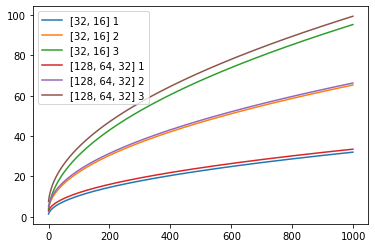

In [25]:
for i, exp in results.iterrows():
    plt.plot(exp['result.test_acc'], label=f'{exp["config.hidden_sizes"]} {exp["config.learning_rate"]}')
plt.legend()
plt.show()

In [26]:
! seml jupyter

Queued Jupyter instance in Slurm job with ID 6536925.
The job's log-file is '/nfs/homedirs/zuegnerd/libraries/seml/examples/tutorial/jupyter-6536925.out'.
Waiting for start-up to fetch the machine and port of the Jupyter instance... (ctrl-C to cancel fetching)
Slurm job is running. Jupyter instance is starting up...
Start-up completed. The Jupyter instance is running at 'gpu13.kdd.in.tum.de:8888'.
To stop the job, run 'scancel 6536925'.


In [27]:
! scancel 6536925